In [48]:
from __future__ import print_function

from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
    
from PIL import Image

from six.moves import range

from keras.datasets import mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1337)

# images are 32 by 32 pixles
img_size = 32
# data contrains sybols represeting: lower case and uppercase letters, and numbers 0-9
num_classes = 26 + 26 + 10
# there are 1016 fonts in the data set
num_fonts = 1016
# total number of samples
num_samples = num_fonts * num_classes

latent_size = 32

In [5]:
def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., n, m, 1)
    cnn = Sequential()

    cnn.add(Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
    cnn.add(Reshape((3, 3, 384)))

    # upsample to (8, 8, ...)
    cnn.add(Conv2DTranspose(filters=192, kernel_size=6, strides=1, padding='valid',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (16, 16, ...)
    cnn.add(Conv2DTranspose(filters=96, kernel_size=5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (32, 32, ...)
    cnn.add(Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same',
                            activation='tanh',
                            kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    cls = Embedding(num_classes, latent_size,
                    embeddings_initializer='glorot_normal')(image_class)

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)

In [6]:
temp = Sequential()

temp.add(Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
temp.add(Reshape((3, 3, 384)))

# upsample to (7, 7, ...)
temp.add(Conv2DTranspose(filters=192, kernel_size=6, strides=1, padding='valid',
                        activation='relu',
                        kernel_initializer='glorot_normal'))

# upsample to (14, 14, ...)
temp.add(Conv2DTranspose(filters=96, kernel_size=5, strides=2, padding='same',
                        activation='relu',
                        kernel_initializer='glorot_normal'))
temp.add(BatchNormalization())

# upsample to (28, 28, ...)
temp.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same',
                        activation='tanh',
                        kernel_initializer='glorot_normal'))

temp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3456)              114048    
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 3, 384)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 192)         2654400   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 96)        460896    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 96)        384       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 1)         865       
Total params: 3,230,593
Trainable params: 3,230,401
Non-trainable params: 192
________________________________________________________________

In [7]:
def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(img_size, img_size, 1)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(img_size, img_size, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])

In [14]:
# batch and latent size taken from the paper
epochs = 3
batch_size = 100
latent_size = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

# build the discriminator
print('Discriminator model:')
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
discriminator.summary()

Discriminator model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 16384)        387840      input_7[0][0]                    
__________________________________________________________________________________________________
generation (Dense)              (None, 1)            16385       sequential_6[1][0]               
__________________________________________________________________________________________________
auxiliary (Dense)               (None, 62)           1015870     sequential_6[1][0]               
Total params: 1,420,095
Trainable params: 1,420,095
Non-trainable params: 0
____________

In [15]:
# build the generator
generator = build_generator(latent_size)

latent = Input(shape=(latent_size, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model([latent, image_class], [fake, aux])

print('Combined model:')
combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
combined.summary()

Combined model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 32, 32, 1)    3474105     input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
model_5 (Model)                 [(None, 1), (None, 6 1420095     model_6[1][0]               

In [16]:
# get the font data, and force it to be of shape (..., 32, 32, 1) with
print("Loading fonts data.")
fonts_image_data = np.load('../data/processed/image_matrices_small.npz')
X = fonts_image_data['data'].reshape((num_samples, img_size, img_size, 1))
y = fonts_image_data['labels'] - 1

print('Done.')

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, 
                                                    random_state=0, stratify=y)

num_train, num_test = x_train.shape[0], x_test.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)

Loading fonts data.
Done.


In [17]:
x_train.shape, x_test.shape

((47244, 32, 32, 1), (15748, 32, 32, 1))

In [18]:

for epoch in range(1, epochs + 1):
    print('Epoch {}/{}'.format(epoch, epochs))

    num_batches = int(np.ceil(x_train.shape[0] / float(batch_size)))
    progress_bar = Progbar(target=num_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(num_batches):
        # get a batch of real images
        image_batch = x_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (len(image_batch), latent_size))

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, num_classes, len(image_batch))

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (len(image_batch), 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

        x = np.concatenate((image_batch, generated_images))

        # use one-sided soft real/fake labels
        # Salimans et al., 2016
        # https://arxiv.org/pdf/1606.03498.pdf (Section 3.4)
        soft_zero, soft_one = 0, 0.95
        y = np.array(
            [soft_one] * len(image_batch) + [soft_zero] * len(image_batch))
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # we don't want the discriminator to also maximize the classification
        # accuracy of the auxiliary classifier on generated images, so we
        # don't train discriminator to produce class labels for generated
        # images (see https://openreview.net/forum?id=rJXTf9Bxg).
        # To preserve sum of sample weights for the auxiliary classifier,
        # we assign sample weight of 2 to the real images.
        disc_sample_weight = [np.ones(2 * len(image_batch)),
                              np.concatenate((np.ones(len(image_batch)) * 2,
                                              np.zeros(len(image_batch))))]

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(
            x, [y, aux_y], sample_weight=disc_sample_weight))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise = np.random.uniform(-1, 1, (2 * len(image_batch), latent_size))
        sampled_labels = np.random.randint(0, num_classes, 2 * len(image_batch))

        # we want to train the generator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * len(image_batch)) * soft_one

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels]))

        progress_bar.update(index + 1)

    print('Testing for epoch {}:'.format(epoch))

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (num_test, latent_size))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, num_classes, num_test)
    generated_images = generator.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=False)

    x = np.concatenate((x_test, generated_images))
    y = np.array([1] * num_test + [0] * num_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(
        x, [y, aux_y], verbose=False)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
    sampled_labels = np.random.randint(0, num_classes, 2 * num_test)

    trick = np.ones(2 * num_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    # generate an epoch report on performance
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *discriminator.metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.4f} | {3:<5.4f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))

    # save weights every epoch
    generator.save_weights(
        'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
    discriminator.save_weights(
        'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

    # generate some digits to display
    num_rows = 40
    noise = np.tile(np.random.uniform(-1, 1, (num_rows, latent_size)),
                    (num_classes, 1))

    sampled_labels = np.array([
        [i] * num_rows for i in range(num_classes)
    ]).reshape(-1, 1)

    # get a batch to display
    generated_images = generator.predict(
        [noise, sampled_labels], verbose=0)

    # prepare real images sorted by class label
    real_labels = y_train[(epoch - 1) * num_rows * num_classes:
                          epoch * num_rows * num_classes]
    indices = np.argsort(real_labels, axis=0)
    real_images = x_train[(epoch - 1) * num_rows * num_classes:
                          epoch * num_rows * num_classes][indices]

    # display generated images, white separator, real images
    img = np.concatenate(
        (generated_images,
         np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0),
         real_images))

    # arrange them into a grid
    img = (np.concatenate([r.reshape(-1, 32)
                           for r in np.split(img, 2 * num_classes + 1)
                           ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

    Image.fromarray(img).save(
        'plot_epoch_{0:03d}_generated.png'.format(epoch))

with open('acgan-history.pkl', 'wb') as f:
    pickle.dump({'train': train_history, 'test': test_history}, f)

Epoch 1/3


C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


473/473 [==============================] - 11277s 24s/step
Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 6.45 | 2.4454          | 4.0073
generator (test)       | 5.60 | 2.5053          | 3.0985
discriminator (train)  | 2.83 | 0.2763          | 2.5520
discriminator (test)   | 2.02 | 0.0746          | 1.9465


ValueError: cannot reshape array of size 40960 into shape (28)

In [42]:
# display generated images, white separator, real images
img = np.concatenate(
    (generated_images,
     np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0),
     real_images))

In [43]:
img.min(), img.max()

(-0.6728735, 1.0)

In [44]:
# arrange them into a grid
img = (np.concatenate([r.reshape(-1, 32)
                       for r in np.split(img, 2 * num_classes + 1)
                       ], axis=-1) * 255).astype(np.uint8)

In [46]:
Image.fromarray(img).save(
    'plot_epoch_{0:03d}_generated.png'.format(epoch))

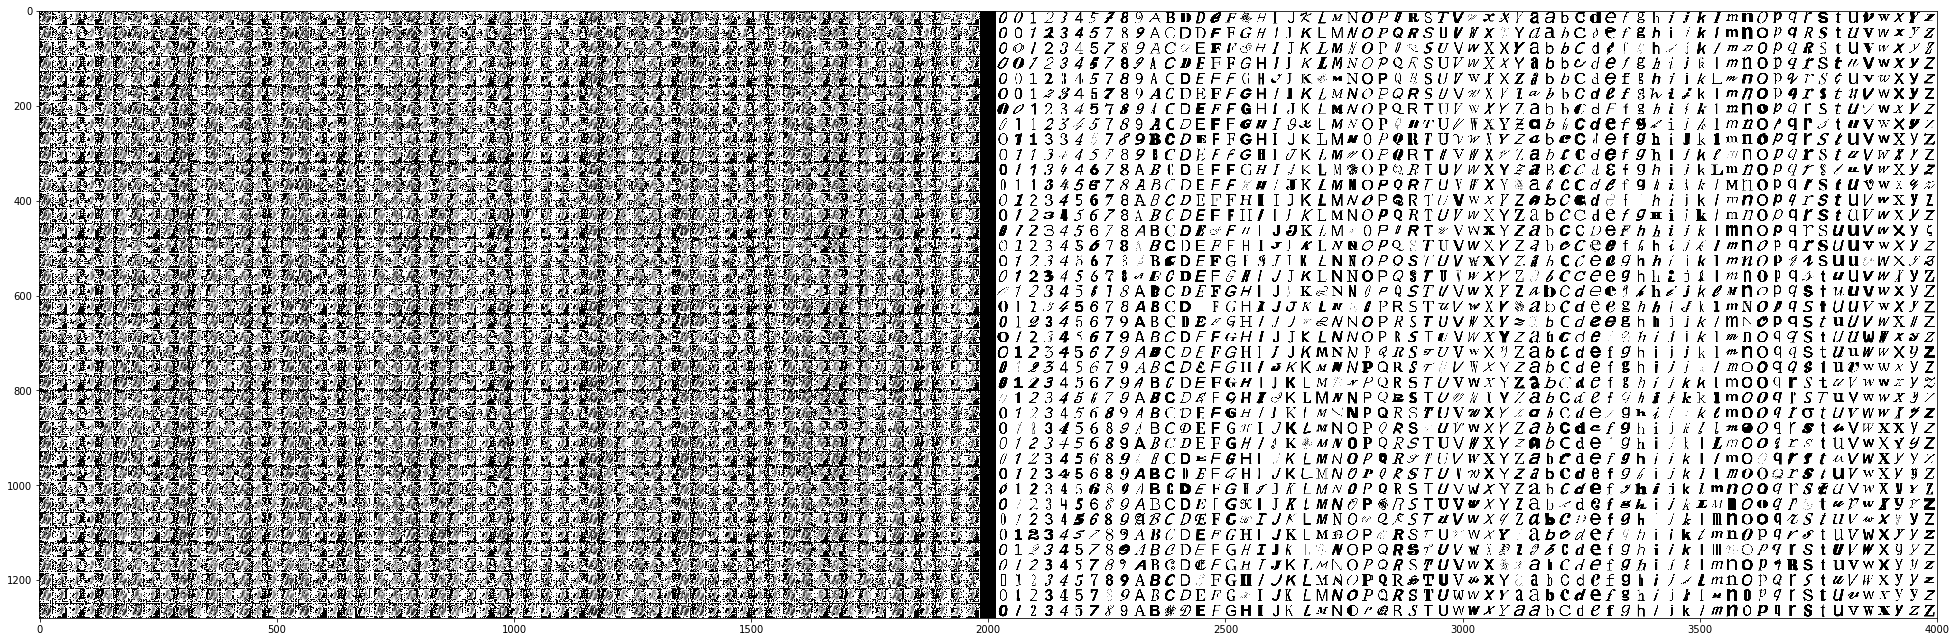

In [51]:
plt.figure(figsize=(34, 64))
plt.imshow(img, cmap=plt.cm.gray_r) 